# 0) LIBRARIES, FUNCTIONS, READ DATA

# Libraries

In [31]:
!pip install scikit-learn >/dev/null
!pip install keras >/dev/null
!pip install scikeras >/dev/null
!pip install gplearn >/dev/null

# Classic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import itertools
import tensorflow as tf
import time
import random
import sklearn
import scikeras
from tensorflow import keras

# ML Modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback

from gplearn.genetic import SymbolicRegressor

from xgboost import XGBRegressor

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

# Other
from google.colab import files

In [32]:
# Set random seed for Python environment
random.seed(16)
# Set random seed for NumPy
np.random.seed(16)
# Set random seed for TensorFlow and Keras
tf.random.set_seed(16)
keras.utils.set_random_seed(16)
tf.config.experimental.enable_op_determinism()

#Functions

In [33]:
def get_xy(data):
    if isinstance(data, np.ndarray):
        X = data[:, :-1]
        y = data[:, -1].reshape(-1, 1)
    elif isinstance(data, pd.DataFrame):
        X = pd.DataFrame(data[data.columns[:-1]].values, columns = list(data.columns[:-1]))
        y = pd.DataFrame(data[data.columns[-1]].values.reshape(-1, 1), columns = data.columns[-1:])
    else:
        raise ValueError("Input data must be either a pandas DataFrame or a numpy array")

    return X, y

In [34]:
def eval_model(model, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    if hasattr(model, 'coef_'):
        coeff = model.coef_
        flat_coeff = coeff.flatten()
    else:
        flat_coeff = None

    if hasattr(model, 'intercept_'):
        intercept = model.intercept_
    else:
        intercept = None

    eval_metrics = {
            'r2': r2,
            'mse': mse,
            'rmse': rmse,
            'coeff': flat_coeff,
            'intercept': intercept
        }

    return eval_metrics

In [35]:
def crossval_model(model, X_train, y_train, X_test, y_test, cv=5, scoring='r2', random_state=16):

    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_splitter, scoring=scoring)
    mean_train_score = np.round(cv_scores.mean(), 3)

    test_score = np.round(model.score(X_test, y_test), 3)

    score_difference = np.abs(mean_train_score - test_score)

    crossval_metrics = {
        'mean_train_score': mean_train_score,
        'test_score': test_score,
        'score_difference': score_difference,
    }

    return crossval_metrics

In [36]:
def crossval_neural(model_func, X_train, y_train, X_test, y_test, epochs, batch_size, cv=5, scoring='r2', random_state=16):
    # Create KerasRegressor wrapper
    keras_regressor = KerasRegressor(model=model_func, epochs=epochs, batch_size=batch_size, verbose=0)

    # Perform cross-validation
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(keras_regressor, X_train, y_train, cv=cv_splitter, scoring=scoring)

    # Compute mean training score
    mean_train_score = np.round(cv_scores.mean(), 3)

    # Fit the model to the entire training data
    keras_regressor.fit(X_train, y_train)

    # Evaluate the model on the test data
    test_score = np.round(keras_regressor.score(X_test, y_test), 3)

    # Compute score difference
    score_difference = np.abs(mean_train_score - test_score)

    # Package cross-validation metrics
    crossval_metrics = {
        'mean_train_score': mean_train_score,
        'test_score': test_score,
        'score_difference': score_difference,
    }

    return crossval_metrics

In [37]:
def get_poly_feature_names(input_features, degree):

  cols = ["bias"]  # Add bias term
  cols.extend(input_features)  # Add original features

  for i in range(2, degree + 1):
    # Squared terms for each original feature
    for feature in input_features:

      cols.append(feature + '^2')
    # Interaction terms (without duplicates)
    for feature_combo in itertools.combinations(input_features, i):
      cols.append('*'.join(feature_combo))


  return cols

In [38]:
def plot_history(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [39]:
def plot_history_lr(history, learning_rate):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

  ax1.plot(history.history['loss'],label='loss')
  ax1.plot(history.history['val_loss'],label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('MSE')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(learning_rate, history.history['loss'],label='learning rate', color = 'indianred')
  ax2.set_xlabel('Learning rate')
  ax2.set_xscale('log')
  ax2.set_ylabel('Loss')
  ax2.legend()

  ax2.grid(True)

  plt.show()

# Read dataset, pin=0



In [40]:
dataset_pd = pd.read_excel("/content/dataset_ml.xlsx")
cols = ["couple", "spec", "temp", "hard_ratio", "cof", "volume"]
dataset_pd["spec"] = (dataset_pd["spec"]=="plate").astype(int)
dataset_pd.head()

,couple,spec,temp,hard_ratio,cof,volume
0,1,1,300,0.899676,0.58,3.976732e+08
1,1,0,300,0.899676,0.58,7.115535e+07
2,1,1,700,0.899676,0.56,4.693081e+07
3,1,0,700,0.899676,0.56,2.200536e+07
4,1,1,850,0.899676,0.32,1.652195e+07


# np.arrays and pd.DataFrames

In [41]:
train_pd, test_pd = np.split(dataset_pd.sample(frac=1, random_state=16), [int(0.8*len(dataset_pd))])
dataset_np = np.array(dataset_pd)
train_np, test_np = np.array(train_pd), np.array(test_pd)

#All NUMPY ARRAYS - UNScaled
X_dataset_np = get_xy(dataset_np)[0]
y_dataset_np = get_xy(dataset_np)[1]

X_train_np = get_xy(train_np)[0]
y_train_np = get_xy(train_np)[1]

X_test_np = get_xy(test_np)[0]
y_test_np = get_xy(test_np)[1]

#All PANDAS DATAFRAMES - UNScaled
X_dataset_pd = get_xy(dataset_pd)[0]
y_dataset_pd = get_xy(dataset_pd)[1]

X_train_pd = get_xy(train_pd)[0]
y_train_pd = get_xy(train_pd)[1]

X_test_pd = get_xy(test_pd)[0]
y_test_pd = get_xy(test_pd)[1]

#All NUMPY ARRAYS - Scaled .- MINMAX Good because only positive values
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_np_scaled = scaler_X.fit_transform(X_train_np)
y_train_np_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1))

X_test_np_scaled = scaler_X.transform(X_test_np)
y_test_np_scaled = scaler_y.transform(y_test_np)

#All PANDAS DATAFRAMES - Scaled
X_train_pd_scaled = pd.DataFrame(X_train_np_scaled, columns = list(dataset_pd.columns[:-1]))
y_train_pd_scaled = pd.DataFrame(y_train_np_scaled, columns = dataset_pd.columns[-1:])

X_test_pd_scaled = pd.DataFrame(X_test_np_scaled, columns = list(dataset_pd.columns[:-1]))
y_test_pd_scaled = pd.DataFrame(y_test_np_scaled, columns = dataset_pd.columns[-1:])

# 1) LINEAR REGRESSION

# 1.1) Simple LR

In [42]:
# TRAIN MODEL
# Define, Train
lin_reg = LinearRegression()
lin_reg.fit(X_train_np_scaled, y_train_np_scaled)

# Predict
y_pred_linear_uns = lin_reg.predict(X_test_np_scaled)

# Unscale
y_test_linear = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_linear = scaler_y.inverse_transform(y_pred_linear_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_linear = eval_model(lin_reg, y_test_linear, y_pred_linear)
mse_linear = eval_linear ['mse']
rmse_linear = eval_linear ['rmse']

cross_linear = crossval_model(lin_reg, X_train_np_scaled, y_train_np_scaled, X_test_np_scaled, y_test_np_scaled)
r2_linear_test = cross_linear ['test_score']
r2_linear_train = cross_linear ['mean_train_score']

eval_linear, cross_linear

({'r2': 0.4152267057111816,
  'mse': 1.901620563318949e+16,
  'rmse': 137899259.00159684,
  'coeff': array([-0.09123206,  0.20205215, -0.05805395,  0.12209793,  0.58753851]),
  'intercept': array([-0.08081022])},
 {'mean_train_score': 0.238, 'test_score': 0.415, 'score_difference': 0.177})

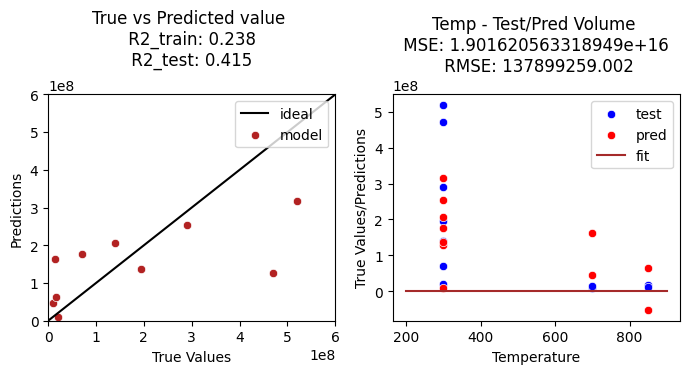

In [43]:
# PLOT
# Create a DataFrame
combo_sns = {
    "y_test_linear": y_test_linear.flatten(),
    "y_pred_linear": y_pred_linear.flatten(),
    "X_test_temp": X_test_np[:, 2],
}
combo_df = pd.DataFrame(combo_sns)

x_t = np.linspace(0, 6e8, 10)
y_t = x_t

# Create subplots using Seaborn
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[0], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_linear', y='y_pred_linear', color='firebrick', ax=axs[0], label='model')
axs[0].set_title(f'True vs Predicted value \n R2_train: {r2_linear_train:.3f} \n R2_test: {r2_linear_test:.3f} \n')
axs[0].set_xlabel('True Values')
axs[0].set_xlim(0,6e8)
axs[0].set_ylabel('Predictions')
axs[0].set_ylim(0,6e8)
axs[0].legend(loc='upper right')

x_fit = np.linspace(200,900,100)
y_fit = eval_linear['intercept'][0] + eval_linear['coeff'][2] * x_fit

sns.scatterplot(data=combo_df, x='X_test_temp', y='y_test_linear', color='b', ax=axs[1], label='test')
sns.scatterplot(data=combo_df, x='X_test_temp', y='y_pred_linear', color='r', ax=axs[1], label='pred')
sns.lineplot(x=x_fit, y=y_fit, color='brown', ax=axs[1], label='fit')
axs[1].set_title(f'Temp - Test/Pred Volume \n MSE: {mse_linear} \n RMSE: {rmse_linear:.3f}')
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel('True Values/Predictions')
axs[1].legend()

plt.tight_layout()
plt.show()

# 1.2) Polynomial LR

In [44]:
# Polynomial features
poly_degree_lr = 2

poly_features_lr = PolynomialFeatures(degree=poly_degree_lr)
X_train_poly = poly_features_lr.fit_transform(X_train_np_scaled)
X_test_poly = poly_features_lr.transform(X_test_np_scaled)

# Define, Train LR with PR
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train_np_scaled)

# Predict
y_pred_poly_uns = poly_reg.predict(X_test_poly)

# Unscale
y_test_poly = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_poly = scaler_y.inverse_transform(y_pred_poly_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_poly = eval_model(poly_reg, y_test_poly, y_pred_poly)
mse_poly = eval_poly ['mse']
rmse_poly = eval_poly ['rmse']

cross_poly = crossval_model(poly_reg, X_train_poly, y_train_np_scaled, X_test_poly, y_test_np_scaled)
r2_poly_test = cross_poly ['test_score']
r2_poly_train = cross_poly ['mean_train_score']

eval_poly, cross_poly

({'r2': -0.2011572506176016,
  'mse': 3.906035637848313e+16,
  'rmse': 197636930.7049751,
  'coeff': array([ 0.        , -2.00109519,  0.14724584, -0.64235328,  0.57759636,
         -0.18939039, -0.05913578,  0.09261425,  0.61863925,  2.61177902,
          1.82484982,  0.14724584, -0.20828108, -0.33134738,  0.13776137,
          0.71418568, -0.73319528, -0.22516229, -1.18676885, -1.47136356,
          0.25704513]),
  'intercept': array([0.45523426])},
 {'mean_train_score': -2.452, 'test_score': -0.201, 'score_difference': 2.251})

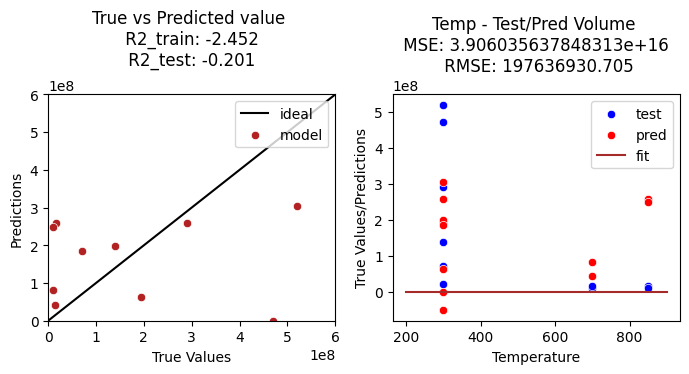

In [45]:
# Create a DataFrame
combo_sns = {
    "y_test_poly": y_test_poly.flatten(),
    "y_pred_poly": y_pred_poly.flatten(),
    "X_test_temp": X_test_np[:, 2],
}
combo_df = pd.DataFrame(combo_sns)

x_t = np.linspace(0, 6e8, 10)
y_t = x_t

# Create subplots using Seaborn
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[0], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_poly', y='y_pred_poly', color='firebrick', ax=axs[0], label='model')
axs[0].set_title(f'True vs Predicted value \n R2_train: {r2_poly_train:.3f} \n R2_test: {r2_poly_test:.3f} \n')
axs[0].set_xlabel('True Values')
axs[0].set_xlim(0,6e8)
axs[0].set_ylabel('Predictions')
axs[0].set_ylim(0,6e8)
axs[0].legend(loc='upper right')

x_fit = np.linspace(200,900,100)
y_fit = eval_linear['intercept'][0] + eval_linear['coeff'][2] * x_fit

sns.scatterplot(data=combo_df, x='X_test_temp', y='y_test_poly', color='b', ax=axs[1], label='test')
sns.scatterplot(data=combo_df, x='X_test_temp', y='y_pred_poly', color='r', ax=axs[1], label='pred')
sns.lineplot(x=x_fit, y=y_fit, color='brown', ax=axs[1], label='fit')
axs[1].set_title(f'Temp - Test/Pred Volume \n MSE: {mse_poly} \n RMSE: {rmse_poly:.3f}')
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel('True Values/Predictions')
axs[1].legend()

plt.tight_layout()
plt.show()

# 2) SUPPORT VECTOR MACHINES

# 2.1) Simple SVR

In [46]:
# TRAIN MODEL
# Define, Train
svm_lin = LinearSVR(max_iter = 5000, random_state=16) # epsilon = 1
svm_lin.fit(X_train_np_scaled, y_train_np_scaled.reshape(-1))

# Predict
y_pred_svm_lin_uns = svm_lin.predict(X_test_np_scaled)

# Unscale
y_test_svm_lin = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1,1))
y_pred_svm_lin = scaler_y.inverse_transform(y_pred_svm_lin_uns.reshape(-1,1))

# Evaluate, Cross validation
eval_svm_lin = eval_model(svm_lin, y_test_svm_lin, y_pred_svm_lin)
mse_svm_lin = eval_svm_lin ['mse']
rmse_svm_lin = eval_svm_lin ['rmse']

cross_svm_lin = crossval_model(svm_lin, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
r2_svm_lin_test = cross_svm_lin ['test_score']
r2_svm_lin_train = cross_svm_lin ['mean_train_score']

eval_svm_lin, cross_svm_lin

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: Futu

({'r2': 0.292481204864952,
  'mse': 2.3007758782824096e+16,
  'rmse': 151683086.67357773,
  'coeff': array([-0.00494767,  0.13731041, -0.04133628,  0.08134355,  0.4276172 ]),
  'intercept': array([-0.07977088])},
 {'mean_train_score': 0.018,
  'test_score': 0.292,
  'score_difference': 0.27399999999999997})

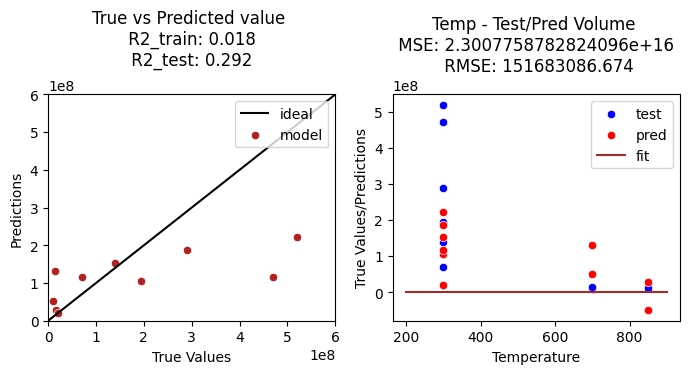

In [47]:
# PLOT
# Create a DataFrame
combo_sns = {
    "y_test_svm_lin": y_test_svm_lin.flatten(),
    "y_pred_svm_lin": y_pred_svm_lin.flatten(),
    "X_test_temp": X_test_np[:, 2],
}
combo_df = pd.DataFrame(combo_sns)

x_t = np.linspace(0, 6e8, 10)
y_t = x_t

# Create subplots using Seaborn
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[0], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_svm_lin', y='y_pred_svm_lin', color='firebrick', ax=axs[0], label='model')
axs[0].set_title(f'True vs Predicted value \n R2_train: {r2_svm_lin_train:.3f} \n R2_test: {r2_svm_lin_test:.3f} \n')
axs[0].set_xlabel('True Values')
axs[0].set_xlim(0,6e8)
axs[0].set_ylabel('Predictions')
axs[0].set_ylim(0,6e8)
axs[0].legend(loc='upper right')

x_fit = np.linspace(200,900,100)
y_fit = eval_linear['intercept'][0] + eval_linear['coeff'][2] * x_fit

sns.scatterplot(data=combo_df, x='X_test_temp', y='y_test_svm_lin', color='b', ax=axs[1], label='test')
sns.scatterplot(data=combo_df, x='X_test_temp', y='y_pred_svm_lin', color='r', ax=axs[1], label='pred')
sns.lineplot(x=x_fit, y=y_fit, color='brown', ax=axs[1], label='fit')
axs[1].set_title(f'Temp - Test/Pred Volume \n MSE: {mse_svm_lin} \n RMSE: {rmse_svm_lin:.3f}')
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel('True Values/Predictions')
axs[1].legend()

plt.tight_layout()
plt.show()

# 2.2) Polynomial SVR

In [48]:
# Polynomial features
poly_degree_svm = 2

poly_features_svm = PolynomialFeatures(degree=poly_degree_svm)
X_train_svm_poly = poly_features_svm.fit_transform(X_train_np_scaled)
X_test_svm_poly = poly_features_svm.transform(X_test_np_scaled)

# Define, Train LR with PR
svm_poly = SVR()
svm_poly.fit(X_train_poly, y_train_np_scaled.reshape(-1))

# Predict
y_pred_smv_poly_uns = svm_poly.predict(X_test_svm_poly)

# Unscale
y_test_svm_poly = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_svm_poly = scaler_y.inverse_transform(y_pred_smv_poly_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_svm_poly = eval_model(svm_poly, y_test_svm_poly, y_pred_svm_poly)
mse_svm_poly = eval_svm_poly ['mse']
rmse_svm_poly = eval_svm_poly ['rmse']

cross_svm_poly = crossval_model(svm_poly, X_train_svm_poly, y_train_np_scaled.reshape(-1), X_test_svm_poly, y_test_np_scaled)
r2_svm_poly_train = cross_svm_poly ['mean_train_score']
r2_svm_poly_test = cross_svm_poly ['test_score']

eval_svm_poly, cross_svm_poly

({'r2': 0.3005544580749333,
  'mse': 2.2745225174211684e+16,
  'rmse': 150815202.06601086,
  'coeff': None,
  'intercept': array([0.40371277])},
 {'mean_train_score': 0.309,
  'test_score': 0.301,
  'score_difference': 0.008000000000000007})

In [49]:
svm_poly.support_, svm_poly.n_support_

(array([ 0,  1,  3,  5,  8, 10, 14, 15, 17, 20, 21, 23, 26, 28, 30, 32, 33,
        34, 37, 39], dtype=int32),
 array([20], dtype=int32))

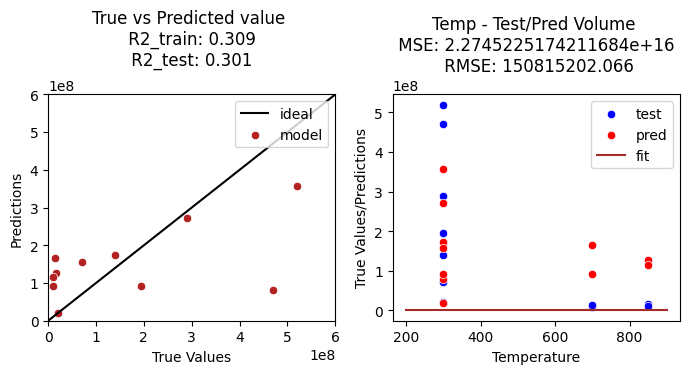

In [50]:
# PLOT
# Create a DataFrame
combo_sns = {
    "y_test_svm_poly": y_test_svm_poly.flatten(),
    "y_pred_svm_poly": y_pred_svm_poly.flatten(),
    "X_test_temp": X_test_np[:, 2],
}
combo_df = pd.DataFrame(combo_sns)

x_t = np.linspace(0, 6e8, 10)
y_t = x_t

# Create subplots using Seaborn
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[0], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_svm_poly', y='y_pred_svm_poly', color='firebrick', ax=axs[0], label='model')
axs[0].set_title(f'True vs Predicted value \n R2_train: {r2_svm_poly_train:.3f} \n R2_test: {r2_svm_poly_test:.3f} \n')
axs[0].set_xlabel('True Values')
axs[0].set_xlim(0,6e8)
axs[0].set_ylabel('Predictions')
axs[0].set_ylim(0,6e8)
axs[0].legend(loc='upper right')

x_fit = np.linspace(200,900,100)
y_fit = eval_linear['intercept'][0] + eval_linear['coeff'][2] * x_fit

sns.scatterplot(data=combo_df, x='X_test_temp', y='y_test_svm_poly', color='b', ax=axs[1], label='test')
sns.scatterplot(data=combo_df, x='X_test_temp', y='y_pred_svm_poly', color='r', ax=axs[1], label='pred')
sns.lineplot(x=x_fit, y=y_fit, color='brown', ax=axs[1], label='fit')
axs[1].set_title(f'Temp - Test/Pred Volume \n MSE: {mse_svm_poly} \n RMSE: {rmse_svm_poly:.3f}')
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel('True Values/Predictions')
axs[1].legend()

plt.tight_layout()
plt.show()

# 3) Neural Networks

# 3.1) Simple MLP Regression

MLP grid search is conducted in **rychly_ml_finetuning.ipynb** because the use of NNs was chosen to examine closely not just here in wide search

# 4) DF + RT

# 4.1) Decision Tree

In [51]:
# TRAIN MODEL
# Define, Train
destree = DecisionTreeRegressor()
destree.fit(X_train_np_scaled, y_train_np_scaled)

# Predict
y_pred_tree_uns = destree.predict(X_test_np_scaled)

# Unscale
y_test_tree = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_tree = scaler_y.inverse_transform(y_pred_tree_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_tree = eval_model(destree, y_test_tree, y_pred_tree)
mse_tree = eval_tree ['mse']
rmse_tree = eval_tree ['rmse']

cross_tree = crossval_model(destree, X_train_np_scaled, y_train_np_scaled, X_test_np_scaled, y_test_np_scaled)
r2_tree_test = cross_tree ['test_score']
r2_tree_train = cross_tree ['mean_train_score']

eval_tree, cross_tree

({'r2': -0.11245548715309628,
  'mse': 3.6175869363529816e+16,
  'rmse': 190199551.4283086,
  'coeff': None,
  'intercept': None},
 {'mean_train_score': -0.215, 'test_score': -0.112, 'score_difference': 0.103})

# 4.2) Random forest

In [52]:
# TRAIN MODEL
# Define, Train
forest = RandomForestRegressor(n_estimators=100, random_state=16)
forest.fit(X_train_np_scaled, y_train_np_scaled.reshape(-1))

# Predict
y_pred_forest_uns = forest.predict(X_test_np_scaled)

# Unscale
y_test_forest = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_forest = scaler_y.inverse_transform(y_pred_forest_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_forest = eval_model(forest, y_test_forest, y_pred_forest)
mse_forest = eval_forest ['mse']
rmse_forest = eval_forest ['rmse']

cross_forest = crossval_model(forest, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
r2_forest_test = cross_forest ['test_score']
r2_forest_train = cross_forest ['mean_train_score']

eval_forest, cross_forest

({'r2': 0.41427381354790294,
  'mse': 1.904719267295368e+16,
  'rmse': 138011567.1708487,
  'coeff': None,
  'intercept': None},
 {'mean_train_score': 0.261,
  'test_score': 0.414,
  'score_difference': 0.15299999999999997})

# 5) XGB



In [53]:
# TRAIN MODEL
# Define, Train
xgb_model = XGBRegressor(n_estimators=100, random_state=16)
xgb_model.fit(X_train_np_scaled, y_train_np_scaled.reshape(-1))

# Predict
y_pred_xgb_uns = xgb_model.predict(X_test_np_scaled)

# Unscale
y_test_xgb = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_xgb = eval_model(xgb_model, y_test_xgb, y_pred_xgb)
mse_xgb = eval_xgb ['mse']
rmse_xgb = eval_xgb ['rmse']

cross_xgb = crossval_model(xgb_model, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
r2_xgb_test = cross_xgb ['test_score']
r2_xgb_train = cross_xgb ['mean_train_score']

eval_xgb, cross_xgb

({'r2': 0.37605565208890446,
  'mse': 2.029000663919442e+16,
  'rmse': 142442994.34929898,
  'coeff': None,
  'intercept': None},
 {'mean_train_score': 0.094,
  'test_score': 0.376,
  'score_difference': 0.28200000000000003})

# 6) GPR

In [54]:
# NONZERO MATRICES AGAINST LOG
# small_value = 1e-10
# X_train_np_scaled_nonzero = np.where(X_train_np_scaled == 0, small_value, X_train_np_scaled)
# y_train_np_scaled_nonzero = np.where(y_train_np_scaled == 0, small_value, y_train_np_scaled)

# TRAIN MODEL
# Define, Train
length_scale_bounds = np.array([1e-100, 1e5])

gpr_model = GaussianProcessRegressor(kernel=RBF(length_scale_bounds = length_scale_bounds), random_state=16)
gpr_model.fit(X_train_np_scaled, y_train_np_scaled)

# Predict
y_pred_gpr_uns = gpr_model.predict(X_test_np_scaled)

# Unscale
y_test_gpr = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_gpr = scaler_y.inverse_transform(y_pred_gpr_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_gpr = eval_model(gpr_model, y_test_gpr, y_pred_gpr)
mse_gpr = eval_gpr['mse']
rmse_gpr = eval_gpr['rmse']

cross_gpr = crossval_model(gpr_model, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
r2_gpr_test = cross_gpr['test_score']
r2_gpr_train = cross_gpr['mean_train_score']

eval_gpr, cross_gpr

({'r2': -0.7449163000944667,
  'mse': 5.674282238838388e+16,
  'rmse': 238207519.5882445,
  'coeff': None,
  'intercept': None},
 {'mean_train_score': -1.3, 'test_score': -0.745, 'score_difference': 0.555})

# 7) GA

"Genetic programming was set with following parameters: Population size = 1000, Maximum generations = 200, Mutation rate = 15%, Tournament selector as selection mechanism, Elites = 1 and Operators = {+, -, ·, /, sin, cos, tan}. Train-test split is 70/30"

In [55]:
from gplearn.functions import make_function

# Define custom functions for sin, cos, and tan
sin = make_function(function=np.sin, name='sin', arity=1)
cos = make_function(function=np.cos, name='cos', arity=1)
tan = make_function(function=np.tan, name='tan', arity=1)

In [56]:
# TRAIN MODEL
# Define the function set including the custom functions
function_set = ['add', 'sub', 'mul', 'div']

# Define and train
ga_model = SymbolicRegressor(population_size=1000,
                              generations=200,
                              tournament_size=20,
                              function_set=function_set,
                              p_crossover=0.7,
                              p_subtree_mutation=0.15,
                              p_hoist_mutation=0.05,
                              p_point_mutation=0.1,
                              verbose=1,
                              parsimony_coefficient=0.01,
                              random_state=16)

ga_model.fit(X_train_np_scaled, y_train_np_scaled.reshape(-1))

# Predict
y_test_ga = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_ga = ga_model.predict(X_test_np_scaled)

# Evaluate, Cross validation
eval_ga = eval_model(ga_model, y_test_ga, y_pred_ga)
mse_ga = eval_ga['mse']
rmse_ga = eval_ga['rmse']

cross_ga = crossval_model(ga_model, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
r2_ga_test = cross_ga['test_score']
r2_ga_train = cross_ga['mean_train_score']

eval_ga, cross_ga, str(ga_model._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.80          18.3913        9         0.247998              N/A      0.17s
   1     8.20         0.353096        5         0.221068              N/A      0.06s
   2     1.20         0.249151        1         0.226408              N/A      0.03s
   3     1.60          1.04948        1         0.226408              N/A      0.02s
   4     1.20         0.239069        1         0.226408              N/A      0.00s
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.80          18.1562        9         0.239749              N/A      0.12s


({'r2': -0.7848827125713915,
  'mse': 5.804248761849049e+16,
  'rmse': 240920085.54392156,
  'coeff': None,
  'intercept': None},
 {'mean_train_score': -1.532, 'test_score': 0.494, 'score_difference': 2.026},
 'X4')